# Backtesting on test set

Betting strategy: To place $1 bet on each horse for each race. If prediction is correct, we will collect $1 x odds. Otherwise, we lose $1

The final result is positive if we win some money and negative if we lose.

For 4 classification models, if there are more than 1 HorseWin in a race in predictions, I will choose the one with smallest odds, since as odds increase, winning probability decreases.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [81]:
# Read in the test file
df_test = pd.read_csv('./data/df_test.csv')
df_test.reset_index(inplace=True, drop=True)
df_test.head()

,finishing_position,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,length_behind_winner,...,running_position_6,race_id,recent_6_runs,recent_ave_rank,race_distance,HorseWin,HorseRankTop3,HorseRankTop50Percent,jockey_ave_rank,trainer_ave_rank
0,1,5.0,POWERMAX,A009,N Callan,R Gibson,126,1124,9,-,...,NaN,2016-328,1/4/3/3,2.750000,1200,1,1,1,6.438751,6.715420
1,2,2.0,BUDDY BUNDY,T157,K K Chiong,D Cruz,127,1193,8,SH,...,NaN,2016-328,2/11/5/2/6/9,6.812500,1200,0,1,1,6.499033,7.381862
2,3,3.0,ROYALE ELEGANCE,S098,O Murphy,W Y So,131,1090,1,1/2,...,NaN,2016-328,3/2/4/4/5/7,4.480000,1200,0,1,1,8.103093,7.048587
3,4,11.0,CONFUCIUS SPIRIT,S329,K Teetan,D E Ferraris,120,1073,2,1-1/4,...,NaN,2016-328,4/3/5/8/2/4,6.484848,1200,0,0,1,6.691367,6.611465
4,5,10.0,STARLIGHT,V273,Z Purton,C H Yip,122,1056,12,1-1/4,...,NaN,2016-328,5/6/14/12,9.250000,1200,0,0,1,5.284127,7.177492


# Backtest the classification predictions

In [94]:
# Define a function to backtest the betting strategy
def class_backtest_strategy(model_pred):

    df_test_results = df_test[['finishing_position', 'win_odds', 'race_id', 'HorseWin', 'horse_id']]

    # rename columns
    df_test_results = df_test_results.rename(columns={'race_id': 'RaceID', 
                                                    'horse_id': 'HorseID', 
                                                    'HorseWin':'ActualWin'})
    
    # merge the prediction with the test data
    df_backtest = pd.merge(model_pred, df_test_results, on=('RaceID', 'HorseID'), how='left')

    money = 0
    bets_made = []
    cumulative_money = [0]

    for race_id in df_backtest['RaceID'].unique():

        # make a temporary dataframe one for that particular race
        temp_df = df_backtest[df_backtest['RaceID']==race_id]

        # find out the bets we made
        bets = temp_df[temp_df['HorseWin']==1]

        # deduct money for bets we made
        deduction  = -len(bets)

        # amount won from bets
        # sum of multiplying the odds with the prediction
        amount_won = sum(bets['win_odds']*bets['ActualWin'])
        
        # add the amount won to the money
        money += (amount_won + deduction)

        # append the money to the cumulative money list
        cumulative_money.append(money)

        # append the bets made to the bets made list
        bets_made.append(len(bets))
    
    # plot the cumulative money
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_money)
    plt.title('Cumulative Money')
    plt.xlabel
    plt.show()

    # plot the bets made
    plt.figure(figsize=(10, 6))
    plt.plot(bets_made)
    plt.title('Bets Made')
    plt.show()

    # print the final money and bets made
    print('Final Money: ', money)
    print('Total Bets Made: ', sum(bets_made))

In [82]:
# Read in our 4 classification predictions

lr = pd.read_csv('lr_pred.csv')
gnb = pd.read_csv('gnb_pred.csv')
rfc = pd.read_csv('rfc_pred.csv')
smote_rfc = pd.read_csv('smote_rfc_pred.csv')

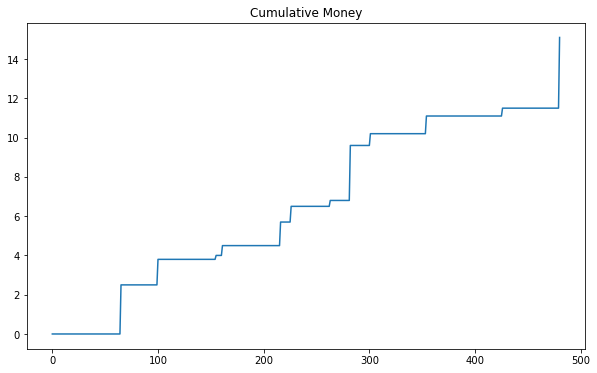

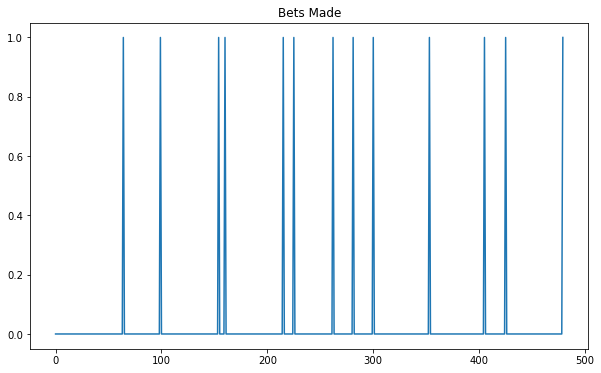

Final Money:  15.1
Total Bets Made:  13


In [95]:
# Backtest the predictions
class_backtest_strategy(lr)

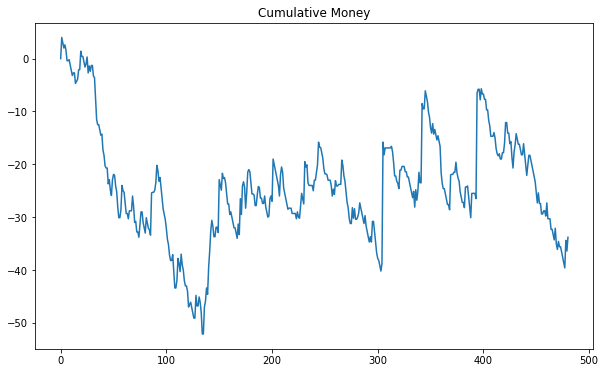

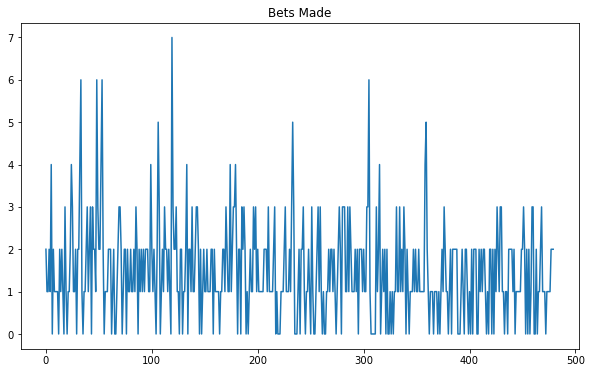

Final Money:  -33.8
Total Bets Made:  706


In [96]:
# Backtest the Naive Bayes predictions
class_backtest_strategy(gnb)

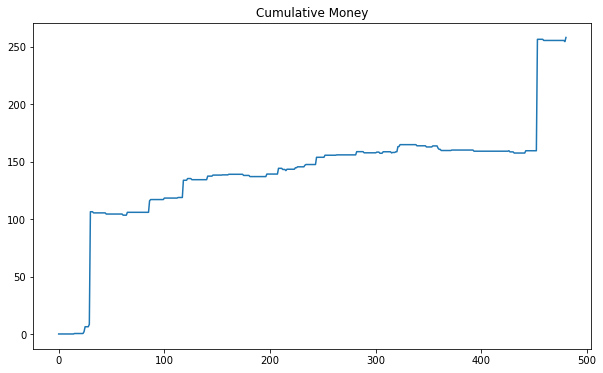

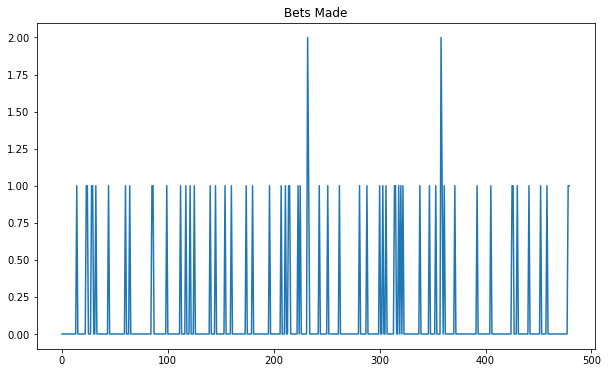

Final Money:  258.1000000000001
Total Bets Made:  63


In [97]:
# Backtest the Random Forest predictions
class_backtest_strategy(rfc)

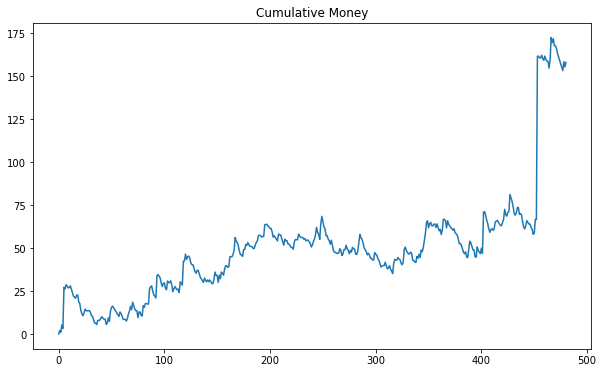

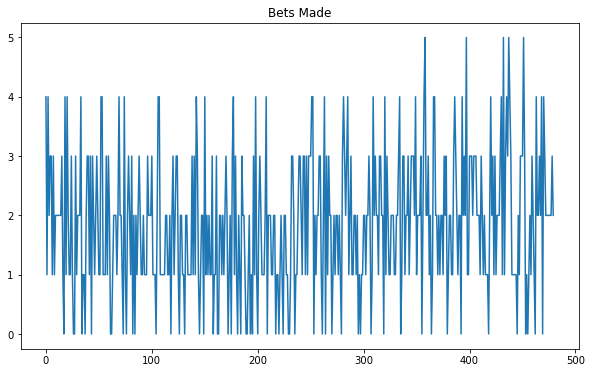

Final Money:  157.89999999999995
Total Bets Made:  883


In [98]:
# Backtest the SMOTE Random Forest predictions
class_backtest_strategy(smote_rfc)

# Backtest the Regression predictions

In [116]:
# Read the csv files for the regression models
ridge = pd.read_csv('ridge_pred.csv')
rf = pd.read_csv('rf_pred.csv')
svr = pd.read_csv('svr_pred.csv')
gbrt = pd.read_csv('gbrt_pred.csv')

In [108]:
# define regression backtest function
def reg_backtest_strategy(model_pred):
        
        df_test_results = df_test[['finishing_position', 'win_odds', 'race_id', 'HorseWin', 'horse_id']]

        # rename columns
        df_test_results = df_test_results.rename(columns={'race_id': 'RaceID', 
                                                        'horse_id': 'HorseID', 
                                                        'HorseWin':'ActualWin'})
        
        # merge the prediction with the test data
        df_test_results['pred_time'] = model_pred['0']

        money = 0
        bets_made = []
        cumulative_money = [0]

        for race_id in df_test_results['RaceID'].unique():

                # make a temporary dataframe one for that particular race
                temp_df = df_test_results[df_test_results['RaceID']==race_id]

                # bet only on the horse with the fastest time
                # return dataframe where the time is the minimum
                bets = temp_df[temp_df['pred_time']==temp_df['pred_time'].min()]

                # deduct money for bets we made
                deduction  = -len(bets)

                # amount won from bets
                # sum of multiplying the odds with the prediction
                amount_won = sum(bets['win_odds']*bets['ActualWin'])
                
                # add the amount won to the money
                money += (amount_won + deduction)

                # append the money to the cumulative money list
                cumulative_money.append(money)

                # append the bets made to the bets made list
                bets_made.append(len(bets))
        
        # plot the cumulative money
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_money)
        plt.title('Cumulative Money')
        plt.xlabel
        plt.show()

        # plot the bets made
        plt.figure(figsize=(10, 6))
        plt.plot(bets_made)
        plt.title('Bets Made')
        plt.show()

        # print the final money and bets made
        print('Final Money: ', money)
        print('Total Bets Made: ', sum(bets_made))
                

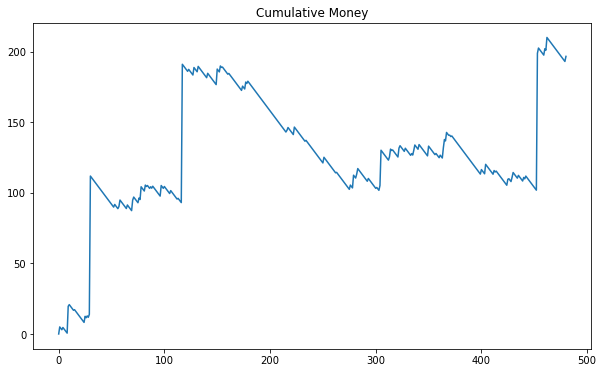

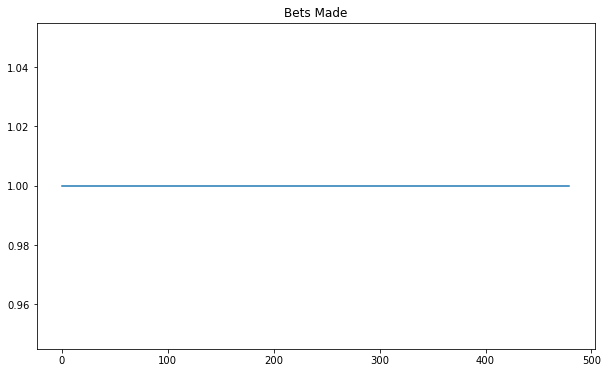

Final Money:  196.70000000000002
Total Bets Made:  480


In [110]:
# Backtest the Ridge Regression predictions
reg_backtest_strategy(ridge)

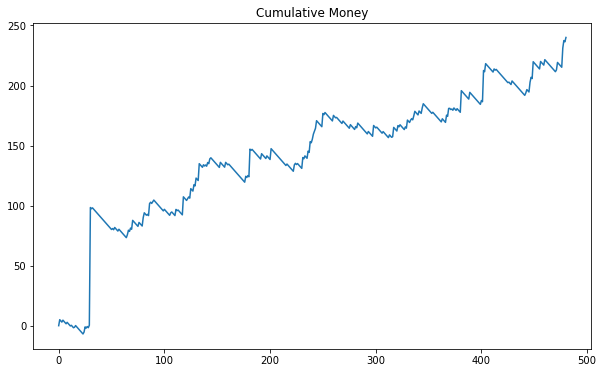

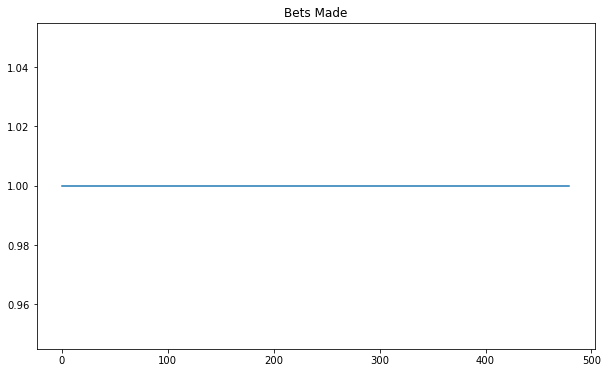

Final Money:  240.00000000000006
Total Bets Made:  480


In [113]:
# Backtest the Random Forest Regression predictions
reg_backtest_strategy(rf)

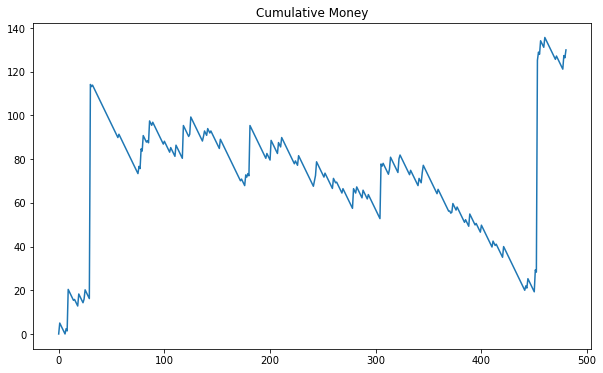

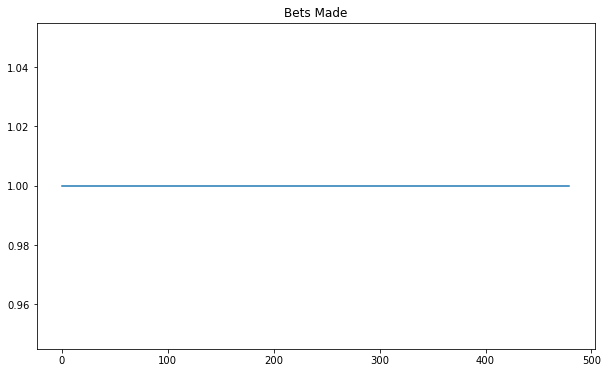

Final Money:  129.99999999999997
Total Bets Made:  480


In [114]:
# Backtest the Support Vector Regression predictions
reg_backtest_strategy(svr)

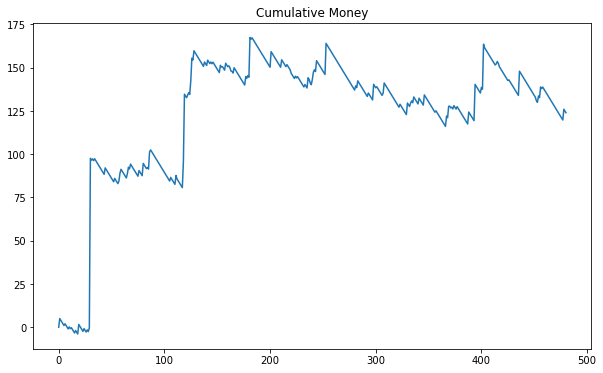

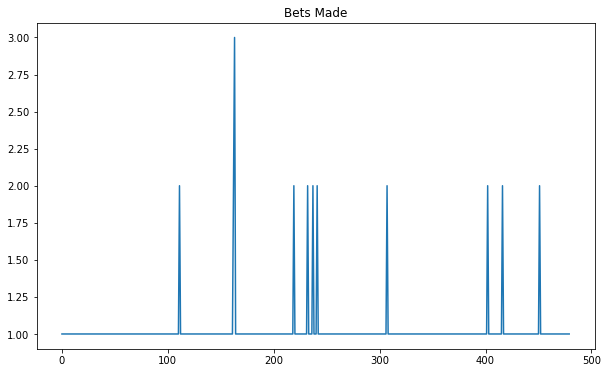

Final Money:  124.00000000000004
Total Bets Made:  492


In [117]:
# Backtest the Gradient Boosting Regression predictions
reg_backtest_strategy(gbrt)